In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp_io
import bct

In [2]:
example_rewired_connectomes = sp_io.loadmat("./data/example_rewired_connectomes.mat")['example_rewired_connectomes']
coordinates = sp_io.loadmat("./data/dk_coordinates.mat")['coordinates']

# Weighted to binary network

In [3]:
n_sub = example_rewired_connectomes.shape[0]
n_node = example_rewired_connectomes.shape[1]
n_edge = n_node * (n_node - 1) // 2
thr = 27
n_sub, n_node, n_edge, thr

(270, 68, 2278, 27)

In [4]:
density = []
binarised_connectomes = []
for i in range(n_sub):
    W_thr = example_rewired_connectomes[i, :, :].copy()
    W_thr[W_thr<thr] = 0
    density.append( (np.triu(W_thr, 1) > 0).sum() / n_edge )
    B = np.zeros(W_thr.shape)
    B[W_thr>0] = 1
    binarised_connectomes.append(B)

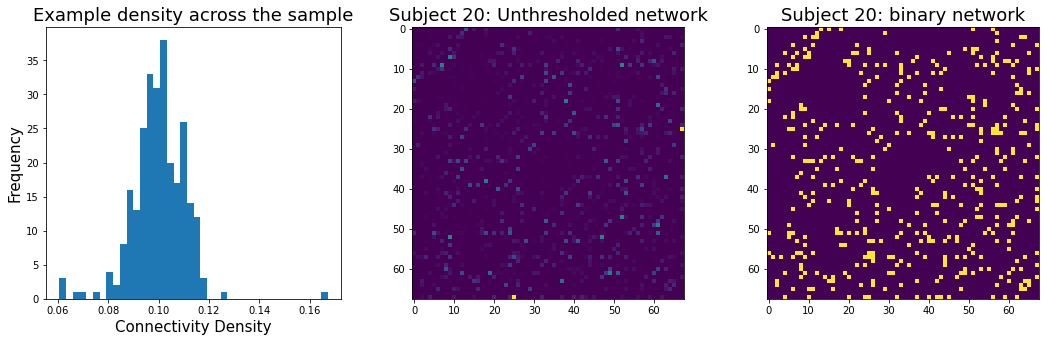

In [5]:
subVis = 20
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(density, bins=40)
plt.xlabel('Connectivity Density', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Example density across the sample', size=18)

plt.subplot(1, 3, 2)
plt.imshow(example_rewired_connectomes[subVis, :, :])
plt.title(f'Subject {subVis}: Unthresholded network', size=18)

plt.subplot(1, 3, 3)
plt.imshow(binarised_connectomes[subVis])
plt.title(f'Subject {subVis}: binary network', size=18)

plt.show()
plt.close()

# Generate seed network

In [6]:
proportion = 0.2
Atgt_set = np.array(binarised_connectomes)
connections = Atgt_set.mean(axis=0)
A = np.zeros(connections.shape)
A[connections==proportion] = 1

In [7]:
degree = (A>0).sum(axis=0)

In [8]:
nz = (Atgt_set.sum(axis=(1, 2)) // 2).astype(int)

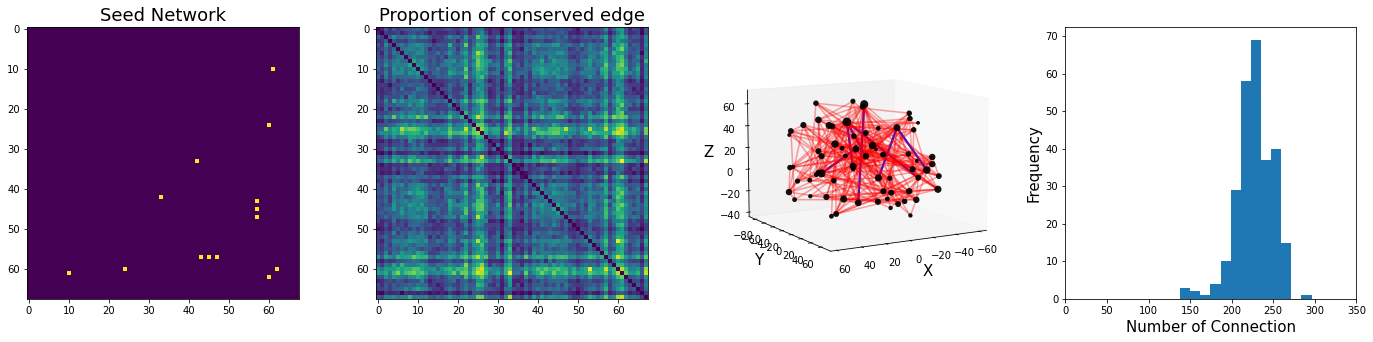

In [9]:
plt.figure(figsize=(24, 5))

plt.subplot(1, 4, 1)
plt.imshow(A)
plt.title('Seed Network', size=18)

plt.subplot(1, 4, 2)
plt.imshow(connections)
plt.title('Proportion of conserved edge', size=18)

ax = plt.subplot(1, 4, 3, projection='3d')
subVis = 120
sub_network = binarised_connectomes[subVis]
sub_degree = (sub_network>0).sum(axis=0).reshape((-1, 1))
sub_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(sub_network) ])
init_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(A) ])

ax.grid(False)
ax.view_init(elev=10, azim=60)
ax.scatter(*coordinates.T, s=sub_degree*3+2, c='black', alpha=0.9)
for edge in init_edge:
    ax.plot(*edge.T, color="blue", alpha=0.75, lw=2)
for edge in sub_edge:
    ax.plot(*edge.T, color="red", alpha=0.2)
ax.set_xlabel('X', size=15)
ax.set_ylabel('Y', size=15)
ax.set_zlabel('Z', size=15)

plt.subplot(1, 4, 4)
plt.hist(nz, bins=20)
plt.xlim(0, 350)
plt.xlabel("Number of Connection", size=15)
plt.ylabel("Frequency", size=15)

plt.show()
plt.close()

# Run generative model

In [10]:
import scipy.spatial as sp_spatial

In [11]:
D = sp_spatial.distance.squareform(sp_spatial.distance.pdist(coordinates, metric="euclidean"))
model_type = ['euclidean', 'neighbors', 'matching', 
             'clu-avg', 'clu-min', 'clu-max', 'clu-diff', 'clu-prod',
             'deg-avg', 'deg-min', 'deg-max', 'deg-diff', 'deg-prod']
model_var  = ['powerlaw', 'powerlaw']

eta_limits = [-7, 7] 
gam_limits = [-7, 7]
n_run = 64
eta = np.linspace(eta_limits[0], eta_limits[1], num=np.sqrt(n_run).astype(int) )
gam = np.linspace(gam_limits[0], gam_limits[1], num=np.sqrt(n_run).astype(int) )
p, q = np.meshgrid(eta, gam)
params = np.array([p.ravel(), q.ravel()]).T
n_params = params.shape[0]

In [30]:
def calc_ks_stat(t1, t2):
    bin_edges = np.concatenate( ([-np.Inf], np.sort(np.concatenate([t1, t2])), [np.Inf]) )
    bin_x, _ = np.histogram(t1, bin_edges)
    bin_y, _ = np.histogram(t2, bin_edges)
    sum_x = bin_x.cumsum()/bin_x.sum()
    sum_y = bin_y.cumsum()/bin_y.sum()
    return np.abs(sum_x[:-1] - sum_y[:-1]).max()

def synth_network_dat_iter(dat):
    for i in range(dat.shape[-1]):
        yield dat[:, :, i]

synth_all, K_all, E_all = {}, {}, {}
for i in range(n_sub):
    synth_all[i], K_all[i], E_all[i] = [], [], []
    
    Atgt = binarised_connectomes[i]
    m = nz[i]
    n = Atgt.shape[0]
    x = [Atgt.sum(axis=1), 
         bct.clustering_coef_bu(Atgt), 
         bct.betweenness_bin(Atgt), 
         D[np.triu(Atgt, k=1).astype(bool)] ]
    np.disp(f"running generative model for subject {i}")
    
    for mt in model_type:
        print(mt, n)
        init_network
        B = bct.generative_model(A.copy(), D, m, eta=params[:, 0], gamma=params[:, 1], model_type=mt, model_var=model_var[0]) # 返回值是各种参数下生成的网络
        KS_stat = []
        for b in synth_network_dat_iter(B):
            y = [b.sum(axis=1),
                 bct.clustering_coef_bu(b),
                 bct.betweenness_bin(b), 
                 D[np.triu(b, k=1).astype(bool)] ]
            KS_stat.append( [ calc_ks_stat(t1, t2)   for t1, t2 in zip(x, y) ])
            break
        KS_stat = np.array(KS_stat)
        synth_all[i].append(B)
        K_all[i].append( KS_stat )
        E_all[i].append( KS_stat.max(axis=1) )
        #break
    break

running generative model for subject 0
euclidean 68
neighbors 68


/mnt/d/software_for_wsl2/miniconda3/lib/python3.8/site-packages/bct/algorithms/generative.py:444: RuntimeWarning: divide by zero encountered in power
  Fd = D ** eta
/mnt/d/software_for_wsl2/miniconda3/lib/python3.8/site-packages/bct/algorithms/generative.py:444: RuntimeWarning: divide by zero encountered in reciprocal
  Fd = D ** eta
/mnt/d/software_for_wsl2/miniconda3/lib/python3.8/site-packages/bct/algorithms/generative.py:389: RuntimeWarning: divide by zero encountered in power
  Fd = D**eta


IndexError: index 2278 is out of bounds for axis 0 with size 2278

In [79]:
u,v = np.where(np.triu(np.ones((n,n)), 1))

In [15]:
import pickle

In [21]:
A, P, r, C = pickle.load(open('./test.pkl', 'rb'))

In [17]:
A_test = A.copy()

print( A_test.sum() )
test_B = bct.generative_model(A_test, D, 321, eta=[params[4, 0]], gamma=[params[0, 1]], model_type=model_type[0], model_var=model_var[0])
print( A_test.sum() )

14.0
1.0 7.0 7
14.0


In [15]:
A_test = A.copy()

print( A_test.sum() )
test_B = bct.generative_model(A_test, D, 321, eta=params[:4, 0], gamma=params[:4, 1], model_type=model_type[0], model_var=model_var[0])
print( A_test.sum() )

14.0
-7.0 7.0 7


/mnt/d/software_for_wsl2/miniconda3/lib/python3.8/site-packages/bct/algorithms/generative.py:444: RuntimeWarning: divide by zero encountered in power
  Fd = D ** eta


IndexError: index 2278 is out of bounds for axis 0 with size 2278

array([-7., -7., -7., -7.])